## Project Setup

**Import  Competition Dataset**

In [ ]:
! pip install kaggle

## API keys:
Upload your own Kaggle API key json file for running the notebook

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahulreddyvemparala","key":"48774fd7a7a3c8ea9a70ce0687a0b23f"}'}

In [ ]:
# move to an appropriate hidden path
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [ ]:
!kaggle competitions download -c gan-getting-started


 98% 359M/367M [00:03<00:00, 124MB/s]
100% 367M/367M [00:03<00:00, 123MB/s]


In [ ]:
# uncomment and run the cell for unzipping the competition data

!unzip gan-getting-started.zip -d gan-getting-started


Streaming output truncated to the last 5000 lines.
  inflating: gan-getting-started/photo_jpg/46e84039a1.jpg  
  inflating: gan-getting-started/photo_jpg/46f391abec.jpg  
  inflating: gan-getting-started/photo_jpg/46f5ef1042.jpg  
  inflating: gan-getting-started/photo_jpg/4706619607.jpg  
  inflating: gan-getting-started/photo_jpg/4707b03a08.jpg  
  inflating: gan-getting-started/photo_jpg/47100a9939.jpg  
  inflating: gan-getting-started/photo_jpg/471f4755b9.jpg  
  inflating: gan-getting-started/photo_jpg/472b351bc4.jpg  
  inflating: gan-getting-started/photo_jpg/472d5ac100.jpg  
  inflating: gan-getting-started/photo_jpg/4758e5dd4c.jpg  
  inflating: gan-getting-started/photo_jpg/4762bb79ef.jpg  
  inflating: gan-getting-started/photo_jpg/4778b13518.jpg  
  inflating: gan-getting-started/photo_jpg/4787b82d37.jpg  
  inflating: gan-getting-started/photo_jpg/478e07feaa.jpg  
  inflating: gan-getting-started/photo_jpg/478eb12a82.jpg  
  inflating: gan-getting-started/photo_jpg/479698

## Pre-processing
- Resize images to 256*256
- Normalize pixel value to (-1, 1)

In [ ]:
import shutil
import os

def delete_directory(directory_path):
    # Remove the contents of the directory
    shutil.rmtree(directory_path, ignore_errors=True)
    print(f'Directory {directory_path} and its contents have been deleted.')

# Replace 'your_directory_path' with the actual path of the directory you want to delete
delete_directory('/content/gan-getting-started/monet_resize_jpg')
delete_directory('/content/gan-getting-started/photo_resize_jpg')


Directory /content/gan-getting-started/monet_resize_jpg and its contents have been deleted.
Directory /content/gan-getting-started/photo_resize_jpg and its contents have been deleted.


## todo: Address this extension jpg.npy

In [ ]:
from PIL import Image
import numpy as np
import os

# Define the paths to your dataset folders
monet_folder = "/content/gan-getting-started/monet_jpg"
photo_folder = "/content/gan-getting-started/photo_jpg"
resize_monet_folder = "/content/gan-getting-started/monet_resize_jpg"
resize_photo_folder = "/content/gan-getting-started/photo_resize_jpg"

# Create resized folders if they don't exist
os.makedirs(resize_monet_folder, exist_ok=True)
os.makedirs(resize_photo_folder, exist_ok=True)

# Define the target size for your images
target_size = (256, 256)

# Function to resize and normalize images
def preprocess_image(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Resize the image to the target size
    image = image.resize(target_size, Image.LANCZOS)  # Use LANCZOS for resampling

    # Convert the image to a NumPy array
    image_array = np.array(image, dtype=np.float32)

    # Normalize pixel values to the range [0, 1]
    image_array /= 255.0

    return image_array

# Iterate through the Monet folder, preprocess, and save the images
for filename in os.listdir(monet_folder)[:5]:
    if filename.endswith(".jpg"):
        image_path = os.path.join(monet_folder, filename)
        preprocessed_image = preprocess_image(image_path)

        # Save the preprocessed image to the resized Monet folder
        save_path = os.path.join(resize_monet_folder, filename)
        np.save(save_path, preprocessed_image)

# Iterate through the Photo folder, preprocess, and save the images
for filename in os.listdir(photo_folder)[:5]:
    if filename.endswith(".jpg"):
        image_path = os.path.join(photo_folder, filename)
        preprocessed_image = preprocess_image(image_path)

        # Save the preprocessed image to the resized Monet folder
        save_path = os.path.join(resize_photo_folder, filename)
        np.save(save_path, preprocessed_image)


In [ ]:
import os

def print_folder_info(folder_path):
    files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

    print(f'Folder Path: {folder_path}')
    print(f'Number of Files: {len(files)}')

# Replace 'your_folder_path' with the actual path of the folder you want to check
print_folder_info('/content/gan-getting-started/monet_resize_jpg')
print_folder_info('/content/gan-getting-started/photo_resize_jpg')


Folder Path: /content/gan-getting-started/monet_resize_jpg
Number of Files: 5
Folder Path: /content/gan-getting-started/photo_resize_jpg
Number of Files: 5


##  Monet, Photo Pair-Generator

In [ ]:
import numpy as np
import os

def get_batch_pairs(monet_folder, photo_folder, batch_size):
    # List all files in the folders
    monet_files = [os.path.join(monet_folder, file) for file in os.listdir(monet_folder) if file.endswith(".jpg.npy")]
    photo_files = [os.path.join(photo_folder, file) for file in os.listdir(photo_folder) if file.endswith(".jpg.npy")]

    # Shuffle the files for random sampling
    np.random.shuffle(monet_files)
    np.random.shuffle(photo_files)

    # Determine the minimum number of files to ensure a balanced batch
    min_files = min(len(monet_files), len(photo_files))

    # Trim the file lists to the minimum number of files
    monet_files = monet_files[:min_files]
    photo_files = photo_files[:min_files]

    # Load the chosen files
    monet_batch = [np.load(file) for file in monet_files]
    photo_batch = [np.load(file) for file in photo_files]

    return np.array(monet_batch), np.array(photo_batch)


import os
import random
import numpy as np

def load_images(monet_path, photo_path, batch_size, file_extension='.npy'):
    monet_files = [file for file in os.listdir(monet_path) if file.endswith(file_extension)]
    photo_files = [file for file in os.listdir(photo_path) if file.endswith(file_extension)]
    random.shuffle(monet_files)
    random.shuffle(photo_files)

    for i in range(0, len(monet_files), batch_size):
        batch_monet_files = monet_files[i:i + batch_size]
        batch_photo_files = photo_files[i:i + batch_size]

        monet_batch = [np.load(os.path.join(monet_path, file)) for file in batch_monet_files]
        photo_batch = [np.load(os.path.join(photo_path, file)) for file in batch_photo_files]

        yield np.array(monet_batch), np.array(photo_batch)


monet_folder = "/content/gan-getting-started/monet_resize_jpg"
photo_folder = "/content/gan-getting-started/photo_resize_jpg"
batch_size = 16

monet_batch, photo_batch = get_batch_pairs(monet_folder, photo_folder, batch_size)


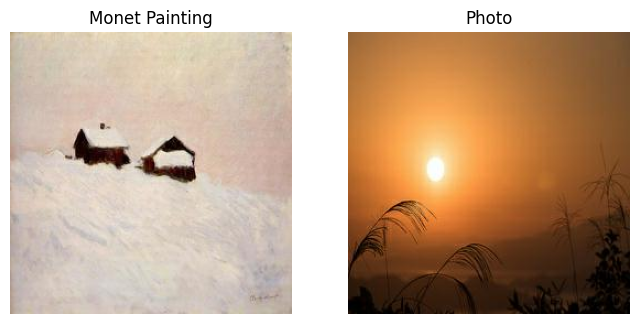

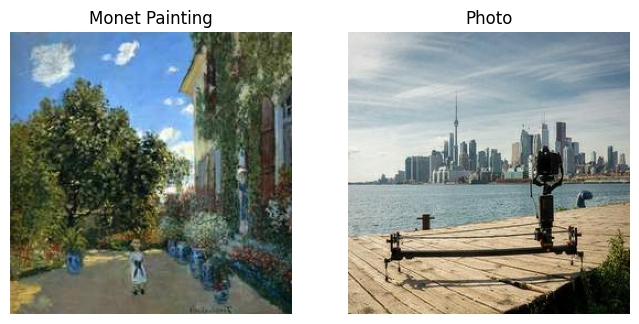

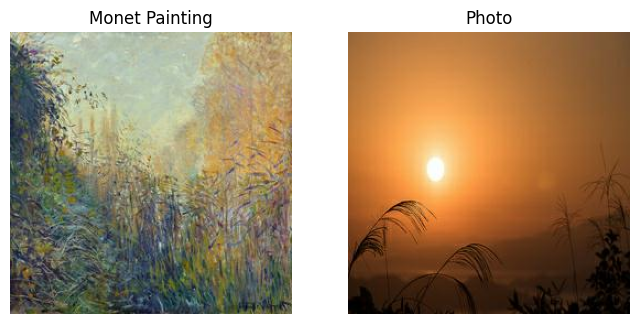

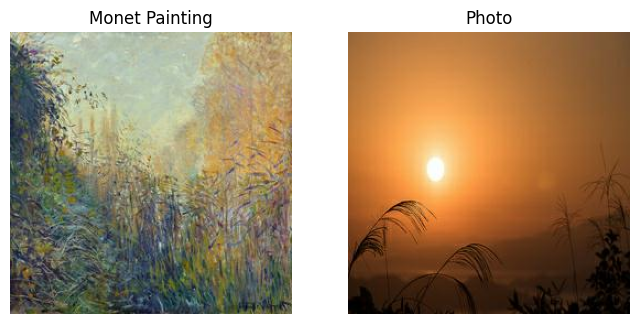

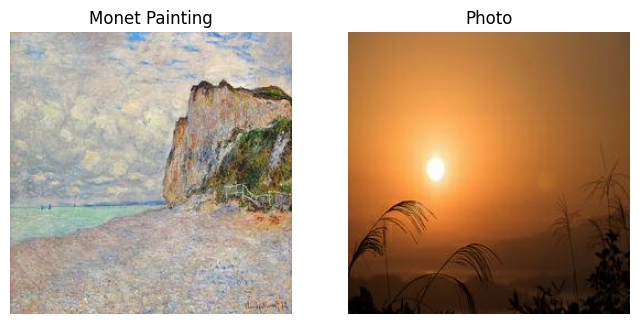

In [ ]:
import matplotlib.pyplot as plt

# Assuming the shape of each image in the batch is (256, 256, 3)
num_pairs_to_visualize = 5

for _ in range(num_pairs_to_visualize):
    # Get a new batch of pairs
    monet_batch, photo_batch = get_batch_pairs(monet_folder, photo_folder, 2)  # Using batch_size of 2 for pairs

    # Display the pair
    plt.figure(figsize=(8, 4))

    # Display Monet painting
    plt.subplot(1, 2, 1)
    plt.imshow(monet_batch[0])
    plt.title("Monet Painting")
    plt.axis("off")

    # Display corresponding photo
    plt.subplot(1, 2, 2)
    plt.imshow(photo_batch[0])
    plt.title("Photo")
    plt.axis("off")

    plt.show()


## Choosing a Pre-trained CNN model for Feature Extraction
- VGG-19 Model for a feature Extractor named "generator" ( **! Not The generator Model**)

In [ ]:
# ! pip install keras

In [ ]:
from keras.applications import VGG19
from keras.models import Model

# Load the pre-trained VGG-19 model without the top (classification) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Extract features from one of the intermediate layers
# You can experiment with different layers to find the best balance between content and style preservation
# Here, I'm using the block4_conv2 layer as an example
generator_output = base_model.get_layer('block4_conv2').output

# Create the generator model
generator = Model(inputs=base_model.input, outputs=generator_output)

# Display the summary of the generator model
generator.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

## Building the Generator

In [ ]:
from keras.layers import Input, UpSampling2D, Conv2D, Activation, BatchNormalization, LeakyReLU, Flatten, Dense
from keras.models import Model
from PIL import Image


# Input layer for the generator
input_shape_generator = (256, 256, 3)  # Change the input shape here
input_tensor_generator = Input(shape=input_shape_generator)

# Upsample the input image to the target size
upsampled_image = UpSampling2D(size=(4, 4))(input_tensor_generator)  # Change the size to match the discriminator input size

# Define convolutional layers for the generator
generator_output = Conv2D(64, (3, 3), padding='same')(upsampled_image)
generator_output = BatchNormalization()(generator_output)
generator_output = Activation('relu')(generator_output)

generator_output = Conv2D(64, (3, 3), padding='same')(generator_output)
generator_output = BatchNormalization()(generator_output)
generator_output = Activation('relu')(generator_output)

# Add the chosen intermediate layer from VGG-19
generator_output = Conv2D(256, (3, 3), padding='same')(generator_output)
generator_output = BatchNormalization()(generator_output)
generator_output = Activation('relu')(generator_output)

# Modify the last layer to produce the desired output shape
generator_output = Conv2D(3, (3, 3), padding='same')(generator_output)
generator_output = BatchNormalization()(generator_output)
generator_output = Activation('tanh')(generator_output)

# Create the generator model
generator_model = Model(inputs=input_tensor_generator, outputs=generator_output)

# Display the summary of the generator model
generator_model.summary()




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 up_sampling2d (UpSampling2  (None, 1024, 1024, 3)     0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 1024, 1024, 64)    1792      
                                                                 
 batch_normalization (Batch  (None, 1024, 1024, 64)    256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1024, 1024, 64)    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1024, 1024, 64)    3692

## Building Discriminator Model

In [ ]:
from keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense
from keras.models import Model

# Input layer for the discriminator
input_shape_discriminator =( 256, 256, 3)
input_tensor_discriminator = Input(shape=input_shape_discriminator)

# Define convolutional layers for the discriminator
discriminator_output = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_tensor_discriminator)
discriminator_output = LeakyReLU(alpha=0.2)(discriminator_output)

discriminator_output = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(discriminator_output)
discriminator_output = LeakyReLU(alpha=0.2)(discriminator_output)

discriminator_output = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(discriminator_output)
discriminator_output = LeakyReLU(alpha=0.2)(discriminator_output)

# Flatten the output and add dense layers
discriminator_output = Flatten()(discriminator_output)
discriminator_output = Dense(1, activation='sigmoid')(discriminator_output)

# Create the discriminator model
discriminator_model = Model(inputs=input_tensor_discriminator, outputs=discriminator_output)

# Display the summary of the discriminator model
discriminator_model.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 256)       0   

## GAN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Input
from keras.models import Model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_model = Sequential()
    gan_model.add(generator)
    gan_model.add(discriminator)
    return gan_model

gan_model = build_gan(generator_model, discriminator_model)


ValueError: ignored

## Defining Various Loss functions

In [ ]:
from keras.losses import binary_crossentropy
from keras.backend import mean

def generator_loss(fake_output):
    return mean(binary_crossentropy(K.ones_like(fake_output), fake_output))

def discriminator_loss(real_output, fake_output):
    real_loss = binary_crossentropy(K.ones_like(real_output), real_output)
    fake_loss = binary_crossentropy(K.zeros_like(fake_output), fake_output)
    return mean(real_loss + fake_loss)


## Training GAN Model

In [ ]:
# ! pip install keras --upgrade
# ! pip install tensorflow --upgrade

In [ ]:
from keras.optimizers import Adam
import numpy as np

# Assuming you've compiled your models
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
generator_model.compile(loss='mae', optimizer=optimizer)

def train_gan(generator, discriminator, gan_model, monet_path, photo_path, epochs, batch_size):
    for epoch in range(epochs):
        for monet_batch, photo_batch in load_images(monet_path, photo_path, batch_size):
            fake_photos = generator.predict(monet_batch)

            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(photo_batch, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_photos, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            valid_labels = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(monet_batch, valid_labels)

            print(f"Epoch {epoch}/{epochs}, [D loss: {d_loss[0]}] [G loss: {g_loss}]")




## Model training

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()


In [ ]:
# Assuming you've compiled your models
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
generator_model.compile(loss='mae', optimizer=optimizer)

# Replace 'monet_path' and 'photo_path' with the actual paths to your Monet and Photo datasets
monet_path = '/content/gan-getting-started/monet_resize_jpg'
photo_path = '/content/gan-getting-started/photo_resize_jpg'

# Call the training loop function
train_gan(generator_model, discriminator_model, gan_model, monet_path, photo_path, epochs=5, batch_size=2)


1/1 [==============================] - 30s 30s/step


ValueError: ignored